<a href="https://colab.research.google.com/github/hannanabdul55/seldonian-fairness/blob/master/logistic_regression_seldonian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
try:
    import seldonian
except:
    !pip install seldonian
import torch
import numpy as np
try:
    import shap
except:
    !pip install shap

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [21]:
from seldonian.seldonian import *
from seldonian.objectives import ghat_tpr_diff, ghat_recall_rate

In [32]:
X, y = shap.datasets.adult()
X_d, y_d = shap.datasets.adult(display=True)

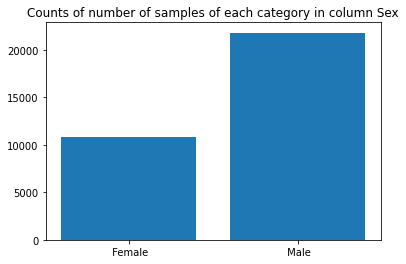

In [33]:
A = 'Sex'
grps = X_d.groupby(A)
counts = {}
for k,v in grps:
    counts[k] = v.shape[0]
plt.bar(counts.keys(), counts.values())
plt.title(f"Counts of number of samples of each category in column {A}")
plt.show()

In [34]:
A_idx = list(X.columns).index(A)
X = X.to_numpy()
X_tr, X_te, y_tr,y_te = train_test_split(X, y, test_size=0.2, random_state=42)
g_hats = [{
    'fn': ghat_recall_rate(A_idx, threshold=0.05),
    'delta': 0.05
}]

In [35]:
model = LogisticRegressionSeldonianModel(X_tr, y_tr, g_hats=g_hats, test_size=0.2, stratify=True)
model.fit()

Optimization terminated successfully.
         Current function value: 4.212527
         Iterations: 10
         Function evaluations: 4117
Optimization result: Optimization terminated successfully.


In [41]:
safe = model._safetyTest()
print(f"The trained model {'failed' if safe>0 else 'passed'} the safety test.")

The trained model passed the safety test.


In [42]:
from sklearn.metrics import accuracy_score

In [43]:
print(f"Constrained model accuracy: {accuracy_score(y_te, model.predict(X_te))}")
print(f"Constrained model violation: {ghat_recall_rate(A_idx, threshold=0.05)(X_te, y_te, model.predict(X_te), 0.05, ub=False)} ")

Constrained model accuracy: 0.6166129279901735
Constrained model violation: -0.04365867811358333 


In [44]:
from sklearn.linear_model import LogisticRegression

uc_model = LogisticRegression(solver='liblinear', random_state=42).fit(X_tr, y_tr)
print(f"Uncontrained model accuracy: {accuracy_score(y_te, uc_model.predict(X_te))}")

Uncontrained model accuracy: 0.8395516658989712


In [47]:
g_theta_test = ghat_recall_rate(A_idx, threshold=0.05)(X_te, y_te, uc_model.predict(X_te), 0.05, ub=False)
print(f"Unconstrained model value of g(\\theta): {g_theta_test}")
print(f"Hence, this model {'failed' if g_theta_test >0 else 'passed'} the safety test")

Unconstrained model value of g(\theta): 0.05761923591488664
Hence, this model failed the safety test
